# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/Users/marceloblinder/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/marceloblinder/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [3]:
def find_digit_indexes(digit, labels):
    '''
    This method return the indexes of the labels that mach 'digit'. For example, if digit is 7
    then this method will return a list with the indexes of all the 7's in labels
    '''
    result = []
    selection = labels == digit # Select the elements of the the class 'digit'
    
    # Get the index of the element of the class 'digit'
    for i in range(len(labels)):
        if selection[i]:
            result.append(i)
            
    return result

def find_not_digit_indexes(digit, labels):
    '''
    This method return the indexes of all the labels that do not match 'digit
    '''
    result = []
    selection = labels != digit # Select the elements that are not of the class 'digit'
    
    # Get the index of the element of the class 'digit'
    for i in range(len(labels)):
        if selection[i]:
            result.append(i)
    
    return result

def find_digits_subset(digit, labels, num_selected):
    '''
    This method get a random selection of the selected digit. For example, if this method is 
    called like 'find_digits(5, train_labels, 10)' then the method will return a list of size
    10 where each element is a randomly selected index of a train_label for the digit 5
    '''
            
    # Return a random sample, of size 'num_selected', of the indexes for the class 'digit'
    return np.random.choice(find_digit_indexes(digit, labels), num_selected)

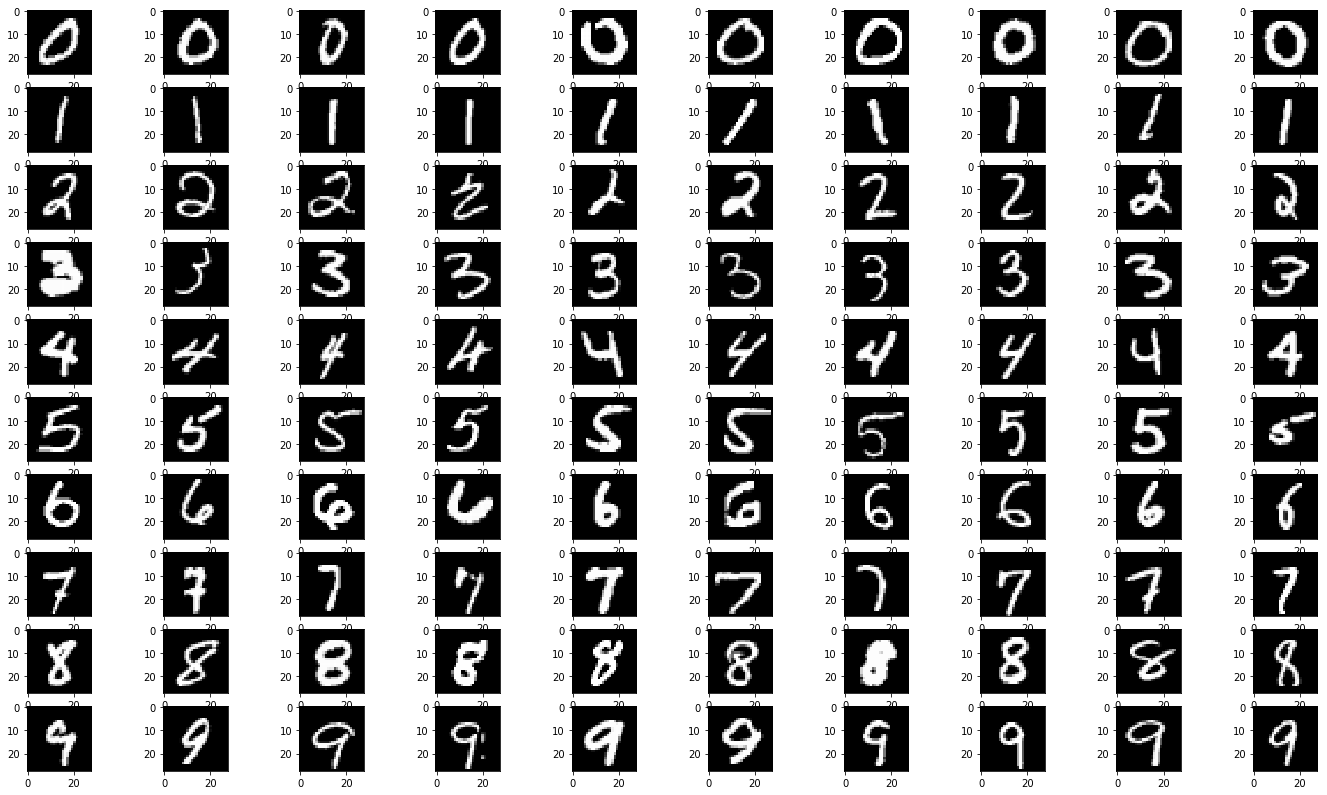

In [4]:
def P1(num_examples=10):

### STUDENT START ###
    plt.rcParams['figure.figsize'] = [24, 14]     # Increase the size of the pictures to make it easier to see the digits
    plt.rc('image', cmap='gray')
    current_plot_index = 1
    
    # Create a plot for each digit
    for digit in range(0, 10):
        indexes = find_digits_subset(digit, train_labels, num_examples)
        img_size = int(np.sqrt(len(train_data[0])))
        
        # Display a row with 'num_example' of 'digit'
        for image_index in range(num_examples):
            image = train_data[indexes[image_index]].reshape(img_size, img_size)
            plt.subplot(num_examples, num_examples, current_plot_index)
            plt.imshow(image)
            current_plot_index += 1
### STUDENT END ###

P1()                                          # Plot the digits

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
def accuracy(true_labels, predicted_labels):
    return sum(true_labels == predicted_labels) / len(true_labels)

In [6]:
def P2(k_values):

### STUDENT START ###
    accuracies = []
    
    for k in k_values:   
        classifier = KNeighborsClassifier(k) # Create the classifier

        # Fit the training data and predict using the dev set
        classifier.fit(mini_train_data, mini_train_labels)
        y_predicted = classifier.predict(dev_data)
        accuracies.append(accuracy(dev_labels, y_predicted))

        if k == 1:
            # Show the full report for k = 1
            print(classification_report(dev_labels, y_predicted))

    # Create the header for the table of K vs Accuracy
    print()
    print('K\tAccuracy')
    print('-\t--------')
    
    # Display the percentage of the predictions that were correct
    for k, accuracy_k in zip(k_values, accuracies):
        print('%i\t%f' % (k, accuracy_k))
         
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000


K	Accuracy
-	--------
1	0.888000
3	0.878000
5	0.869000
7	0.865000
9	0.863000


ANSWER: For k=1 the most difficult digit was **9**. It has one of the lowest precision (78%), one of the lowest recalls (82%) and the lowest F1 score (which combines the precision and the recall).

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [7]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    classifier = KNeighborsClassifier(1) # Create the classifier
    total_times = []

    for size in train_sizes:
        start_time = time.time() # Starting time for training set of size 'size'
        
        # Fit the training data and predict using the dev set. Only 'size' items
        # from the training set are used for the training.
        classifier.fit(train_data[:size], train_labels[:size])
        y_predicted = classifier.predict(dev_data)
        accuracies.append(accuracy(dev_labels, y_predicted))
        total_times.append(time.time() - start_time)
        
    return total_times
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
total_times = P3(train_sizes, accuracies)

print('Size\tAccuracy\tTotal time (sec)')
print('----\t--------\t----------------')
for size, accuracy_for_size, total_time in zip(train_sizes, accuracies, total_times):
    print('%i\t%f\t%f' % (size, accuracy_for_size, total_time))

Size	Accuracy	Total time (sec)
----	--------	----------------
100	0.720000	0.096720
200	0.786000	0.186073
400	0.841000	0.379692
800	0.884000	0.852220
1600	0.902000	1.769110
3200	0.926000	3.638320
6400	0.937000	7.251202
12800	0.959000	16.047143
25000	0.970000	32.433349


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [8]:
def P4():

### STUDENT START ###
    model = LinearRegression()
    
    x = np.array(train_sizes).reshape(-1, 1)
    y = np.array(accuracies).reshape(-1, 1)
    model.fit(x, y)
    
    predicted_value = model.predict(np.array([[ 60000 ]]))[0][0]
    
    print('The predicted value for n = 60000 is %f' % predicted_value)
### STUDENT END ###

P4()

The predicted value for n = 60000 is 1.243072


ANSWER: The issue is that accuracy is a between 0 and 1 and the relationship between the size and the accuracy is not linear (see plot below). The simple linear regression gives an answer that is meaningless for n=60000.

If instead of using:

$$ accuracy = \beta_0 + \beta_1 \cdot size $$

Use:

$$ ln(\frac{accuracy}{1 - accuracy}) = \beta_0 + \beta_1 \cdot ln(size)$$

Using the last equation, the accuracy for n=60000 is:

In [9]:
def log_linear_estimate(x, y, x0):
    '''
    This method fit a model of the type: ln(y / (1 - y)) = beta0 + beta1 * ln(x)
    and then use that model to predict y, given x
    '''
        
    # First ransform the variables
    x = np.log(np.array(train_sizes).reshape(-1, 1))
    y = np.array(accuracies).reshape(-1, 1)
    y = np.log(y / (1 - y))
    
    # Then fit a linear model
    model = LinearRegression()
    model.fit(x, y)
    
    # And finally predict y for x0
    predicted_value = model.predict(np.array([[ np.log(x0) ]]))[0][0] # Calculate beta0 + beta1 * ln(x0)
    predicted_value = np.exp(predicted_value) # Calculate the value of accuracy / (1 - accuracy)
    predicted_value = predicted_value / (1 + predicted_value) # Calculate the final value for the accuracy
    
    return predicted_value

print(log_linear_estimate(train_sizes, accuracies, 60000))

0.978514195447


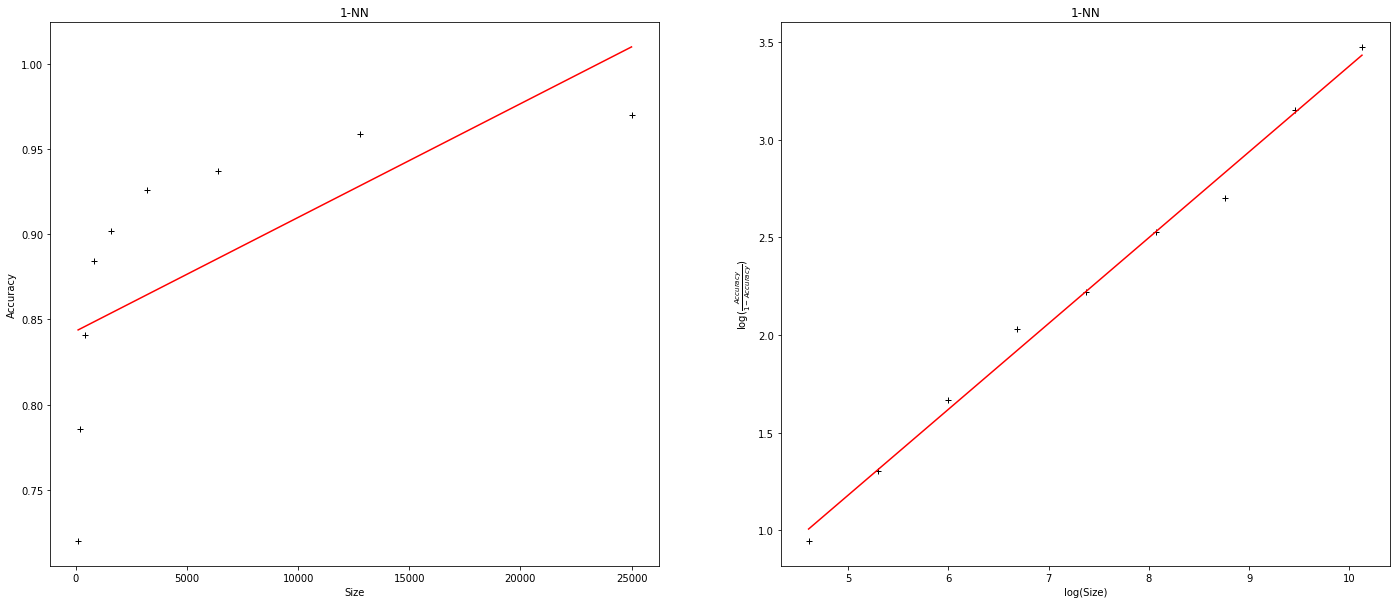

In [10]:
def plot_accuracy_graphs():
    '''
    Create two plots, one of size x accuracy and the ln(accuracy / (1 - accuracy)) x ln(size)    
    '''
    
    plt.rcParams['figure.figsize'] = [24, 10]     # Increase the size of the pictures to make it easier to see the digits

    # Create the plot of the size x accuracy
    model = LinearRegression() # Used to display the best-fit linear model
    x = np.array(train_sizes).reshape(-1, 1)
    y = np.array(accuracies).reshape(-1, 1)
    model.fit(x, y)
    plt.subplot(121)
    plt.xlabel('Size')
    plt.ylabel('Accuracy')
    plt.title('1-NN')
    plt.plot(x, y, '+', color='black')
    plt.plot(x, model.predict(x), color='red')

    # Create the plot of the ln(size) x ln(accuracy / (1 - accuracy))
    x = np.log(np.array(train_sizes).reshape(-1, 1))
    y = np.array(accuracies).reshape(-1, 1)
    y = np.log(y / (1 - y))
    model.fit(x, y)
    plt.subplot(122)
    plt.xlabel('log(Size)')
    plt.ylabel(r'log($\frac{Accuracy}{1 - Accuracy})$')
    plt.title('1-NN')
    plt.plot(x, y, '+', color='black')
    plt.plot(x, model.predict(x), color='red')
    
plot_accuracy_graphs()

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [11]:
def normalize_matrix(matrix):
    '''
    Return a new matrix where the cells are normalized (for each image, the pixels sum up to 1)
    '''
    return matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

def calculate_confusion_matrix(normalize=False):
    '''
    Return the confusion matrix (the classifier is trained with the mini_train_data and
    evaluated using the dev_data)
    '''
    
    classifier = KNeighborsClassifier(1) # Create the classifier
    classifier.fit(mini_train_data, mini_train_labels)
    
    cm = confusion_matrix(dev_labels, classifier.predict(dev_data))
    
    return normalize_matrix(cm) if normalize else cm

In [12]:
# Based on the sample from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = normalize_matrix(cm)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def find_false_negative_images(classifier, digit):
    '''
    Find the images that are 'digit' but were classified as something else.
    (for example, find 9's that were classified as some other digit)
    '''
    
    indexes = find_digit_indexes(digit, dev_labels) # Indexes of 'digit' on the dev set
    digit_samples = dev_data[indexes] # Save the images of 'digit' on the dev set
    
    # Return the subset of 'digit_samples' that the classifier did not classify correctly
    return digit_samples[classifier.predict(dev_data[indexes]) != digit]

def find_false_positive_images(classifier, digit):
    '''
    Find the images that are not 'digit' but were classified as 'digit'.
    (For example, find images that were classified as 9 but are not 9's)
    '''
    
    indexes = find_not_digit_indexes(digit, dev_labels) # Indexes of all images that are not 'digit'
    not_digit_samples = dev_data[indexes] # All the images that are not 'digit' on the dev set
    
    # Return the subset of 'not_digit_samples' that were incorrectly classified as 'digit'
    return not_digit_samples[classifier.predict(dev_data[indexes]) == digit]  

def display_images(images, num_examples, title):
    '''
    When this method is called it displays a row of images
    '''
    plt.figure()
    plt.rc('image', cmap='gray')
    plt.title(title)
    current_plot_index = 1
    img_size = int(np.sqrt(len(train_data[0])))
        
    for image_index in range(num_examples):
        image = images[image_index].reshape(img_size, img_size)
        plt.subplot(1, num_examples, current_plot_index)
        plt.imshow(image)
        current_plot_index += 1
        
    plt.show()

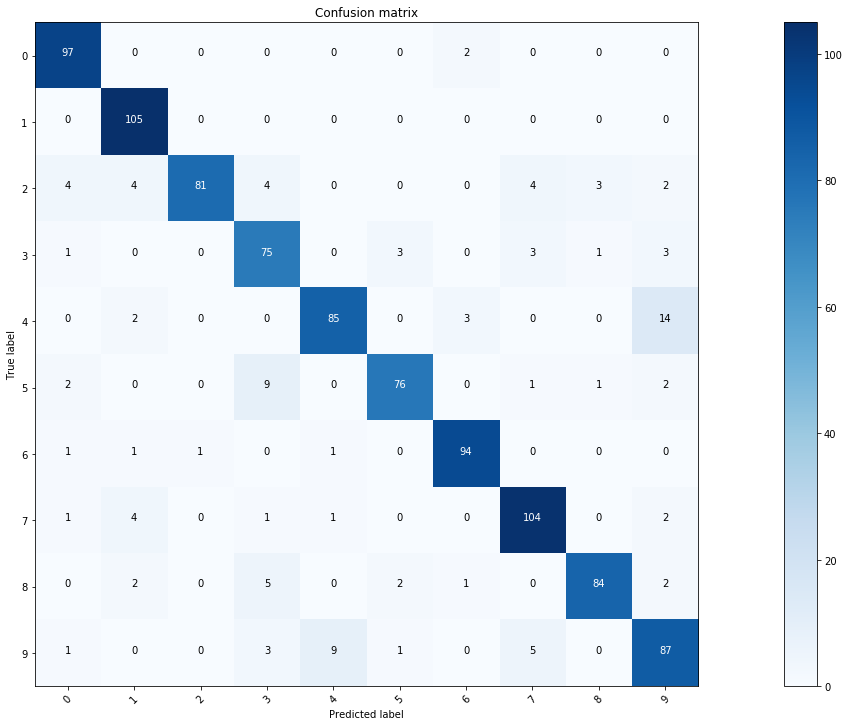

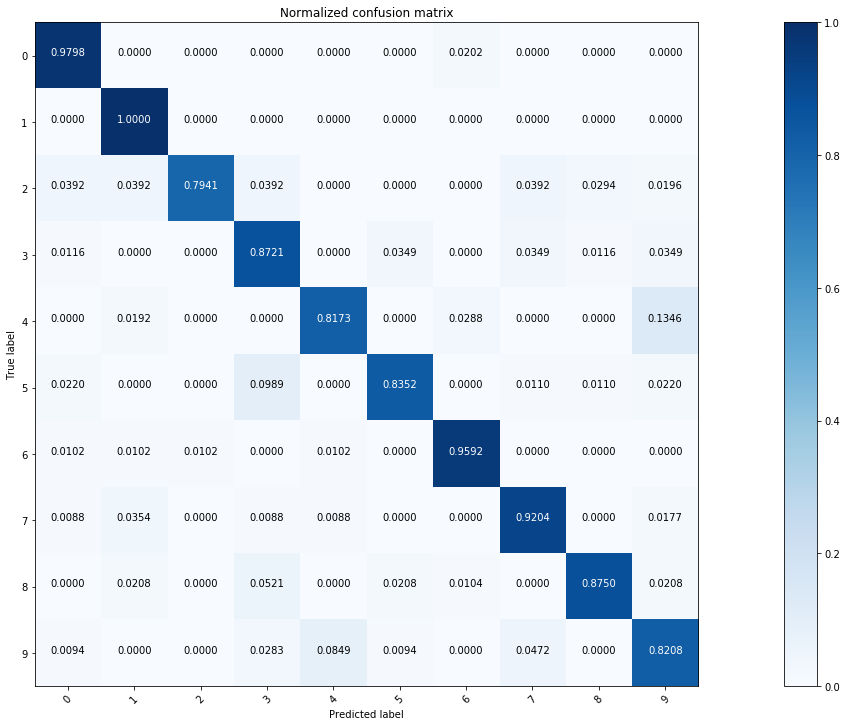

<Figure size 1728x720 with 0 Axes>

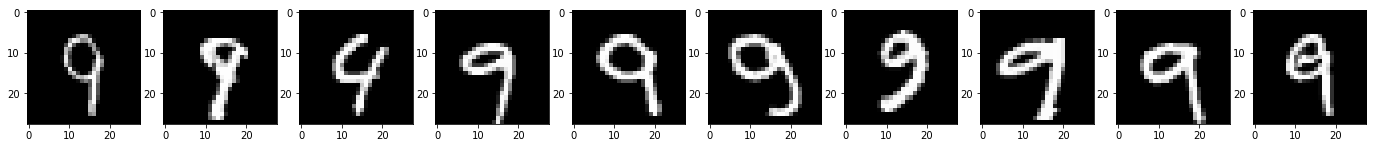

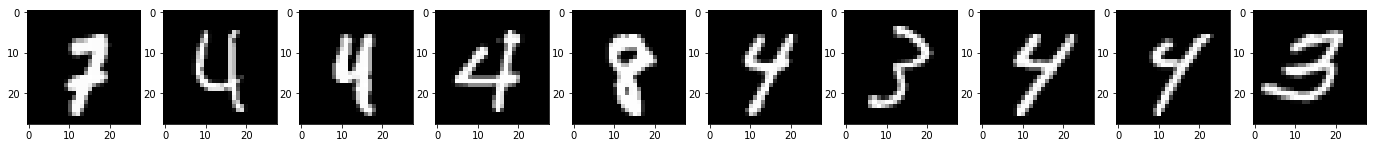

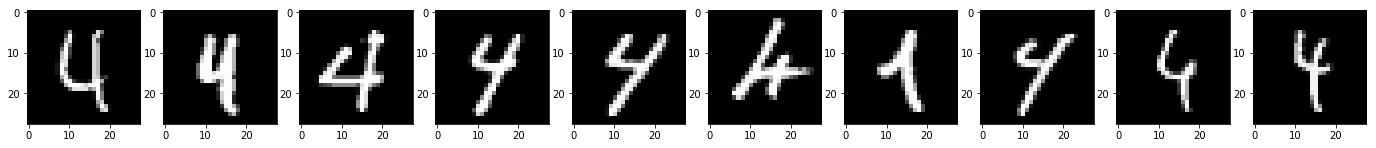

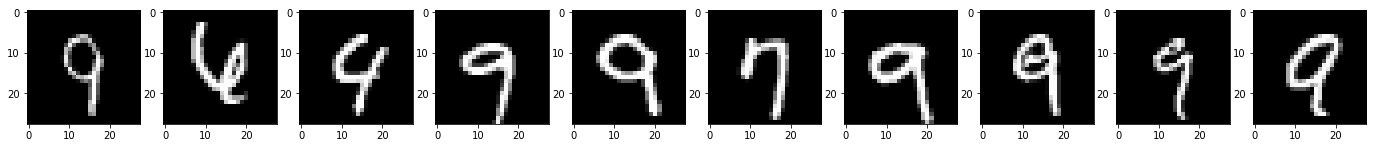

In [13]:
def P5():

### STUDENT START ###
    # Plot confusion matrix
    plt.rcParams['figure.figsize'] = [24, 10]     # Increase the size of the pictures to make it easier to see the digits
    plt.figure()
    plot_confusion_matrix(calculate_confusion_matrix(), classes=list(range(10)), normalize=False, title='Confusion matrix')
    plt.show()

    # Plot the normalized confusion matrix
    plt.rcParams['figure.figsize'] = [24, 10]     # Increase the size of the pictures to make it easier to see the digits
    plt.figure()
    plot_confusion_matrix(calculate_confusion_matrix(), classes=list(range(10)), normalize=True, title='Normalized confusion matrix')
    plt.show()
  
    # Now show a few of the digits that were not classified correctly
    plt.figure()
    plt.rc('image', cmap='gray')
    current_plot_index = 1
    
    # Create a 1-NN classifier and train it
    classifier = KNeighborsClassifier(1) # Create the classifier
    classifier.fit(mini_train_data, mini_train_labels)

    # Display the digits that were incorrecly classified
    num_examples = 10
    display_images(find_false_negative_images(classifier, 9), num_examples, "True 9's incorrectly classified")
    display_images(find_false_positive_images(classifier, 9), num_examples, "Incorrecly classified as 9")
    display_images(find_false_negative_images(classifier, 4), num_examples, "True 4's incorrectly classified")
    display_images(find_false_positive_images(classifier, 4), num_examples, "Incorrecly classified as 4")
### STUDENT END ###

P5()

The most consufed pair of digits were __4__ and __9__. The pictures above show the regular and normalized confusion matrices and on those it can be seen that 4 and 9 have the lowest accuracies. The image above show 9's that were not classified correctly, other digits that were incorrectly classified as 9, 4 that were incorrecly classified and other digits that were incorrecly classified as 4.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [14]:
def gaussian_blur_filter(original_image):
    '''
    Apply a simple gaussian filter to the image. The smoothed value is calculated:
    
    (current_pixel + neighbors_avg) / 2
    neighbors_avg = sum(neighbor_pixel) / 8
    '''
    
    size = int(np.sqrt(original_image.shape[0])) # Save the original size of image (lenght=width in this case)
    image = np.zeros(original_image.shape) # Create an array fill with zeros that will contain the smoothed image
    image = image.reshape(size, size) # Re-shape the array into a matrix-like format
    original_image = original_image.reshape(size, size) # Re-shape the original image into an matrix-like format
    
    # Loop over the rows and the columns
    for row in range(1, size - 1):
        for column in range(1, size - 1):
            # The next lines calculate the average of the neighboor pixels
            top_row = original_image[row - 1, column - 1] + original_image[row - 1, column] + original_image[row - 1, column + 1]
            current_row = original_image[row, column - 1] + original_image[row, column + 1]
            bottom_row = original_image[row + 1, column - 1] + original_image[row + 1, column] + original_image[row + 1, column + 1]
            average = (top_row + current_row + bottom_row) / 8
            
            # Calculate the average between the current pixel and the neighbor pictures
            image[row, column] = (original_image[row, column] + average) / 2
    
    # Re-store the shape of the original image (make it look like an array again)
    original_image.flatten()
    
    # Return the smoothed image as an array
    return image.flatten()

def get_neighbors(row, column, num_rows, num_columns):
    '''
    This method returns an array with the index of the neighbor points. A point can have 8, 5 or 3 neighbors
    '''
    
    result = [ (row - 1, column - 1), (row - 1, column), (row - 1, column + 1),
               (row, column - 1), (row, column + 1),
               (row + 1, column - 1), (row + 1, column), (row + 1, column + 1) ] # First add 8 possible neighbor point
    result = [cell for cell in result if cell[0] >= 0 and cell[0] < num_rows] # Remove the points beyond the left and right borders
    result = [cell for cell in result if cell[1] >= 0 and cell[1] < num_columns] # Remove the points beyond the top and bottom borders
    
    return result
    
def distance_squared(p1, p2):
    '''
    Calculate the square distance between two points
    '''
    
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

def get_multipliers(row, column, num_rows, num_columns):
    '''
    Calculate the multipliers used to smooth the image
    '''
    
    # First calculate the squared distance between the current pixel and all the neighbor pixels
    multipliers = [distance_squared((row, column), cell) for cell in get_neighbors(row, column, num_rows, num_columns)]
    multipliers.append(0) # The current point is at the end of the array
    multipliers = np.exp(-np.array(multipliers) / 2) # Calculate exp(-d^2)
    multipliers = multipliers / multipliers.sum() # Normalize the multipliers to ensure that their sum is 1
                         
    return multipliers
                         
def gaussian_blur_filter2(original_image):
    '''
    Calculate a smoothed image where the smoothing factor is based on exp(-d^2) of the 
    distance from the current pixel.
    '''
    
    size = int(np.sqrt(original_image.shape[0]))
    image = np.zeros(original_image.shape)
    image = image.reshape(size, size) 
    original_image = original_image.reshape(size, size)
    
    for row in range(1, size - 1):
        for column in range(1, size - 1):
            neighboors = get_neighbors(row, column, size, size)
            pixels = [original_image[cell[0], cell[1]] for cell in get_neighbors(row, column, size, size)]
            pixels.append(original_image[row, column])
            image[row, column] = (np.array(pixels) * get_multipliers(row, column, size, size)).sum()            
    
    # Restore the shape of the original image
    original_image.flatten()
    
    return image.flatten()   

In [15]:
def P6():
    
### STUDENT START ###
    classifier = KNeighborsClassifier(1) # Create the classifier
    
    # Create the smoothed dev and train sets 
    mini_train_data_smoothed = [gaussian_blur_filter(i) for i in mini_train_data]
    dev_data_smoothed = [gaussian_blur_filter(i) for i in dev_data]
  
    # Report the results with no smoothing
    print('No change')
    classifier.fit(mini_train_data, mini_train_labels) 
    y_predicted = classifier.predict(dev_data)
    print(classification_report(dev_labels, y_predicted, digits=4))

    # Report the results using just the smoothed training set
    print('Training set smoothed')
    classifier.fit(mini_train_data_smoothed, mini_train_labels) 
    y_predicted = classifier.predict(dev_data)
    print(classification_report(dev_labels, y_predicted, digits=4))
    
    # Report the results using just the dev set
    print('Dev set smoothed')
    classifier.fit(mini_train_data, mini_train_labels) 
    y_predicted = classifier.predict(dev_data_smoothed)
    print(classification_report(dev_labels, y_predicted, digits=4))

    # Report the results using both the smoothed train and dev sets
    print('Both sets smoothed')
    classifier.fit(mini_train_data_smoothed, mini_train_labels) 
    y_predicted = classifier.predict(dev_data_smoothed)
    print(classification_report(dev_labels, y_predicted, digits=4))      
### STUDENT END ###

P6()

No change
             precision    recall  f1-score   support

        0.0     0.9065    0.9798    0.9417        99
        1.0     0.8898    1.0000    0.9417       105
        2.0     0.9878    0.7941    0.8804       102
        3.0     0.7732    0.8721    0.8197        86
        4.0     0.8854    0.8173    0.8500       104
        5.0     0.9268    0.8352    0.8786        91
        6.0     0.9400    0.9592    0.9495        98
        7.0     0.8889    0.9204    0.9043       113
        8.0     0.9438    0.8750    0.9081        96
        9.0     0.7768    0.8208    0.7982       106

avg / total     0.8924    0.8880    0.8878      1000

Training set smoothed
             precision    recall  f1-score   support

        0.0     0.9238    0.9798    0.9510        99
        1.0     0.9286    0.9905    0.9585       105
        2.0     0.9767    0.8235    0.8936       102
        3.0     0.8085    0.8837    0.8444        86
        4.0     0.9239    0.8173    0.8673       104
        5.

ANSWER: Smoothing the training had the best result. It improved both the precision, recall and F1-score. Pre-processing only the training data and dev sets also improved the results. The results were worse when only the dev set were smoothed. 

For this exercise, two different types of pre-processing were experimented with. One first calculates the average of the eight surrounding pixes:

$$ average\_of\_neighbors = \sum_0^8(x_i)$$

After that it averages that value with the the value of the current pixed:

$$ final\_value = \frac{average\_of\_neighbors + current\_pixel}{2}$$

Any point that does not have 8 neightbor pictures is not smoothed.

The second type of pre-processing (implemented at __gaussian_blur_filter2__) give a weight to each pixed equals to:

$$ weight\_of\_pixel = \frac{e^{-\frac{d^2}{2}}}{\sum_{i=0}^n{weight\_of\_pixel_i}} $$

Where d is the distance to the current pixed. In this case, i=0 for the current pixed and n can be 4 (for the pixels on both borders), 6 (for the pixels that are on the border) or 9 (for all the other pixels that are in the center).

The results were very similar for both cases. Because of that, the results from the tables above use the first smoothing, because it is simpler.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [16]:
def report_accuracy(train_data, train_labels, dev_data, dev_labels, classifier):
    '''
    Method that takes a generic classifier, train it on (train_data, train_labels) and
    report the accuracy on (dev_data, dev_labels)
    '''
    
    classifier.fit(train_data, train_labels)
    pred = classifier.predict(dev_data)
    
    return accuracy(dev_labels, pred)

def bernoulli_classifier_accuracy(train_data, train_labels, dev_data, dev_labels, threashold=.01):
    '''
    Report the accuracy for a Bernoulli classifier
    '''
    
    return report_accuracy(train_data, train_labels, dev_data, dev_labels, BernoulliNB(binarize=threashold))

def preprocess_image(image, threasholds):
    '''
    Pre-process a single image. The pixels are mapped to 0, 1 and 2 
    '''
    
    result = np.zeros(image.shape) # Create a image with only zeros  
    result[(image >= threasholds[0]) & (image < threasholds[1])] = 1 # Set to 1 if the pixel is between the two value
    result[image >= threasholds[1]] = 2 # Set the pixel to 2 if it is bigger than the second threashold
    
    return result

def preprocess_images(images, threasholds = [ 1/3, 2/3 ]):
    '''
    Pre-process a set of images. The pixels will be mapped to 0, 1 and 2
    '''
    
    preprocessed_images = np.zeros(images.shape)
    
    for i in range(images.shape[1]):
        preprocessed_images[i] = preprocess_image(train_data[i], threasholds)    
    
    return preprocessed_images

def multinomial_classifier_accuracy(train_data, train_labels, dev_data, dev_labels, threasholds = [ 1/3, 2/3 ]):
    '''
    Report the accuracy on a Multinomial classifier
    '''
    
    train_data_preprocessed = preprocess_images(train_data)
    classifier = MultinomialNB()
        
    return report_accuracy(train_data_preprocessed, train_labels, dev_data, dev_labels, classifier)

In [17]:
def P7():

### STUDENT START ###
    accuracy_bernoulli = bernoulli_classifier_accuracy(mini_train_data, mini_train_labels, dev_data, dev_labels)
    print("Accuracy for Bernoulli NB: %f" % accuracy_bernoulli)

    accuracy_multinomial = multinomial_classifier_accuracy(mini_train_data, mini_train_labels, dev_data, dev_labels)
    print("Accuracy for Multinomial NB: %f" % accuracy_multinomial)
### STUDENT END ###

P7()

Accuracy for Bernoulli NB: 0.815000
Accuracy for Multinomial NB: 0.799000


ANSWER: The Multinomial NB model does not improve the accuracy if compared with the Bernoulli NB model. For most of the images the majority of the points is either 0 or 1 (see histograms below). Therefore, adding a new level between 0 and 1 does not add a lot of information. The Multinomial NB model is more complex than the Bernoulli and the increase in complexity increases the variance, without a corresponding increasing the accuracy.

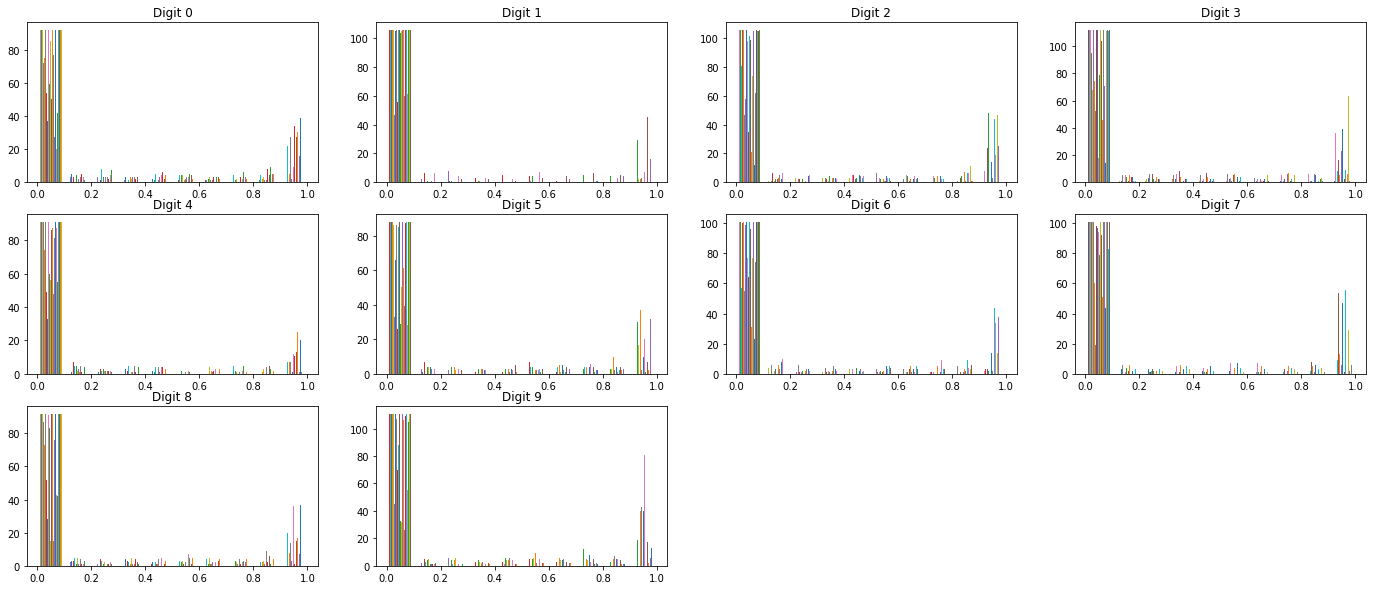

In [18]:
plt.rcParams['figure.figsize'] = [24, 10]     # Increase the size of the pictures to make it easier to see the digits

# plot the histogram of the values for each digit.
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.title('Digit %i' % i)
    #plt.hist(mini_train_data[mini_train_labels == i].sum(axis=0) / mini_train_data.shape[0])
    plt.hist(mini_train_data[mini_train_labels == i])


(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [19]:
def P8(alphas):

### STUDENT START ###
    classifier = BernoulliNB(binarize=.5)
    gs = GridSearchCV(classifier, alphas)
    gs.fit(mini_train_data, mini_train_labels)
    
    return gs
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

/Users/marceloblinder/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/marceloblinder/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/marceloblinder/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [20]:
print(nb.best_params_)

{'alpha': 0.01}


In [21]:
def plot_cv_result(gs):
    y = [ i.mean_validation_score for i in gs.grid_scores_ ]
    x = [ i.parameters['alpha'] for i in gs.grid_scores_ ]
    plt.plot(x, y)
    
#plot_cv_result(nb)
nb.grid_scores_

[mean: 0.80300, std: 0.01644, params: {'alpha': 0.0},
 mean: 0.81800, std: 0.02216, params: {'alpha': 0.0001},
 mean: 0.82000, std: 0.02073, params: {'alpha': 0.001},
 mean: 0.82100, std: 0.01811, params: {'alpha': 0.01},
 mean: 0.81500, std: 0.02013, params: {'alpha': 0.1},
 mean: 0.80000, std: 0.01188, params: {'alpha': 0.5},
 mean: 0.79500, std: 0.01145, params: {'alpha': 1.0},
 mean: 0.78400, std: 0.01934, params: {'alpha': 2.0},
 mean: 0.72000, std: 0.02495, params: {'alpha': 10.0}]

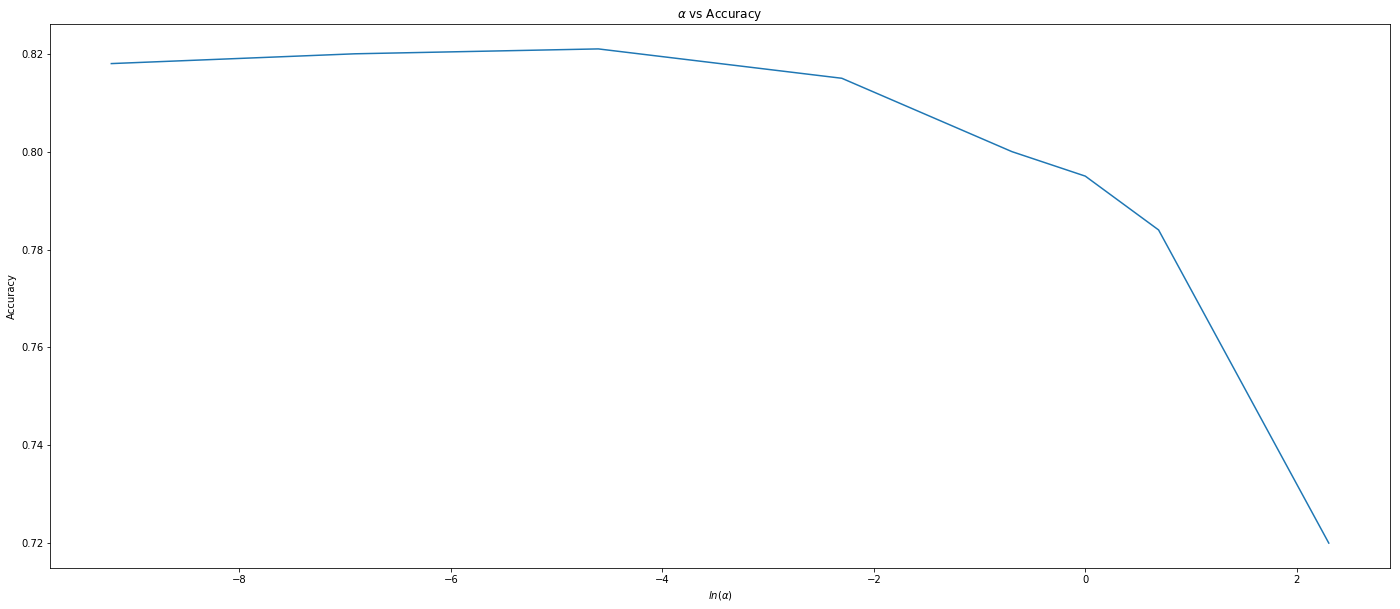

In [22]:
def plot_accuracy_vs_alpha():
    data_points = [i for i in nb.grid_scores_ if i.parameters['alpha'] != 0]
    plt.plot([np.log(i.parameters['alpha']) for i in data_points], 
             [i.mean_validation_score for i in data_points])
    plt.title(r'$\alpha$ vs Accuracy')
    plt.xlabel(r'$ln(\alpha)$')
    plt.ylabel('Accuracy')
              
plot_accuracy_vs_alpha()

ANSWER: The best value for $\alpha$ is .01. For $\alpha=0$ the average error (using cross validation of 3 sets) was 0.80300. It should be expected that using an alpha greater that 0 will improve results (up to a certain point) because it increase the number of pixels that are set to 1. Looking at the histograms of the digits, it seems that most of the values for the pixels are between 0 and .01.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [23]:
def P9():

### STUDENT END ###
    classifier = GaussianNB()     
    classifier.fit(mini_train_data, mini_train_labels)
    
    return classifier
### STUDENT END ###

gnb = P9()

In [24]:
print("Accuracy = %f" % gnb.score(dev_data, dev_labels))

gnb.sigma_ = np.full((10, 784), .0001)
print("Accuracy = %f" % gnb.score(dev_data, dev_labels))    

Accuracy = 0.621000
Accuracy = 0.802000


ANSWER: Just using GaussianNB without changing the accuracy is about 0.621. By setting the sigma parameter (which controls the standard deviation) to some value close to 0, like 0.0001 then the accuracy on the dev set improves to .8020. Most of the values of the digits pixels are close to 0 (see histograms from previous problem). By setting the standard deviation to something small the gaussian classifier will have a behavior similar to the Bernulli classifier.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

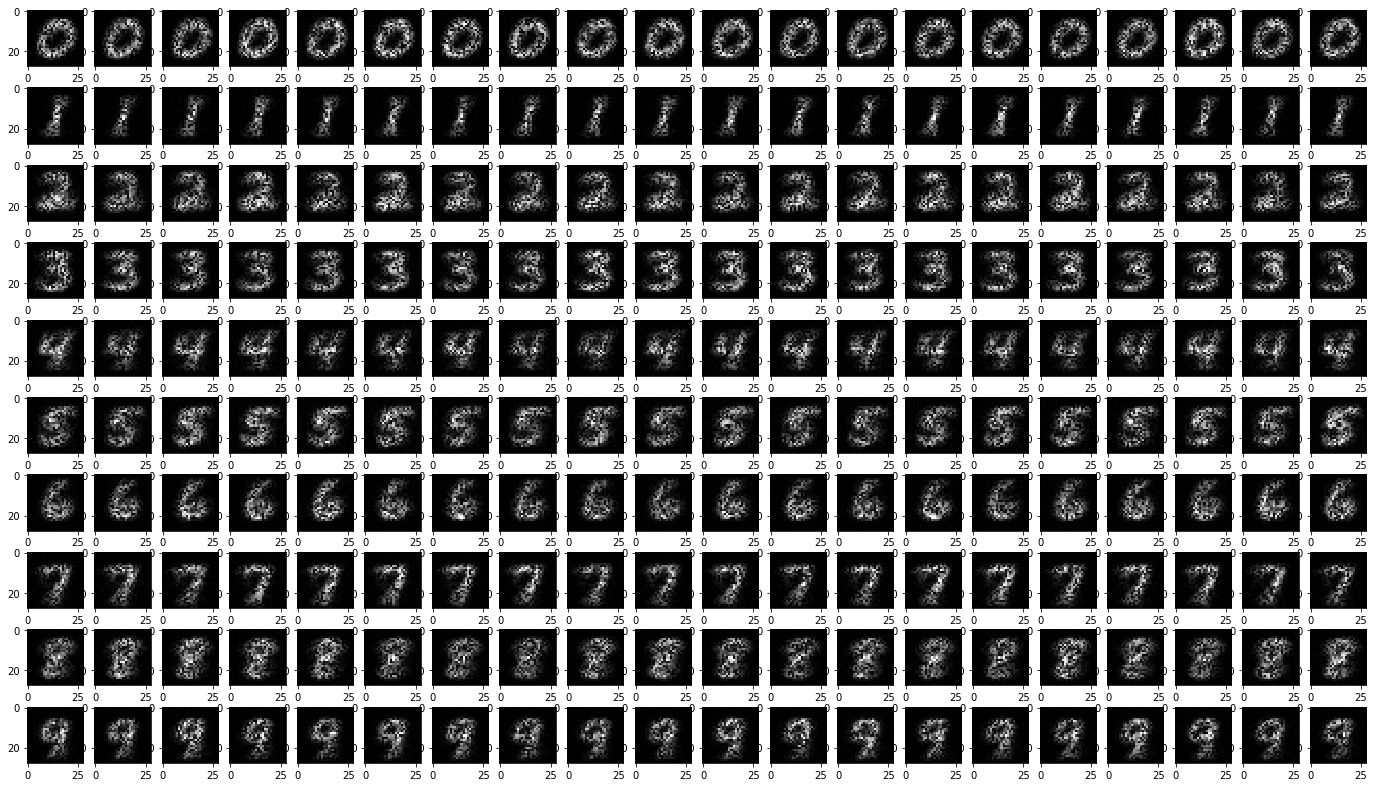

In [25]:
def P10(num_examples):

### STUDENT START ###
    plt.rcParams['figure.figsize'] = [24, 14]     # Increase the size of the pictures to make it easier to see the digits
    plt.rc('image', cmap='gray')
    current_plot_index = 1
    
    # Create and fit the classifier
    classifier = BernoulliNB(binarize = .5)
    classifier.fit(mini_train_data, mini_train_labels)
    
    # Create a random 
    # plt.imshow((np.exp(classifier.feature_log_prob_)[3] * np.random.rand(28 * 28)).reshape(28, 28))
    
    # Create a plot for each digit
    for i in range(0, 10):
        for j in range(0, num_examples):
            plt.subplot(10, num_examples, current_plot_index)
            plt.imshow((np.exp(classifier.feature_log_prob_)[i] * np.random.rand(28 * 28)).reshape(28, 28))
            current_plot_index += 1
### STUDENT END ###

P10(20)

ANSWER: There are some similarity between the random digits and the digits from the training set. However, the randomly generted digits are more uniform than the digits in the training set, there are little variability between different digits of the same class, the generated digits are more uniform that the training digits.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [26]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    # Create and train the classifier
    classifier = BernoulliNB(alpha=.01)
    classifier.fit(mini_train_data, mini_train_labels)
    
    # Make the predictions and calculate the probabilities for the prediction
    predictions = classifier.predict(dev_data)
    probabilities = classifier.predict_proba(dev_data) 
    
    # Loop over the predictions, probabilities and the true values for the dev set and update the 
    # proper buckets
    for prediction, digits_probabilities, true_value in zip(predictions, probabilities, dev_labels):
        index = -1
        probability = digits_probabilities[int(prediction)] # Get the probability for the predicted digit
        
        # Check which bucket needs to be updated
        for i in range(len(buckets) - 1):
            if (buckets[i] <= probability) and (probability < buckets[i + 1]):
                index = i
                break
        
        # Update the total and the number of correct items for the bucket
        total[index] += 1
        correct[index] += int(prediction == true_value) # When (perdiction == true_value) add 1 (int(True) == 1)              
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy_for_bucket = 0.0
    if (total[i] > 0): 
        accuracy_for_bucket = correct[i] / total[i]
        
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy_for_bucket))

p(pred) <= 0.5000000000000    total =  30    accuracy = 0.400
p(pred) <= 0.9000000000000    total =  76    accuracy = 0.447
p(pred) <= 0.9990000000000    total =  51    accuracy = 0.490
p(pred) <= 0.9999900000000    total =  62    accuracy = 0.581
p(pred) <= 0.9999999000000    total =  44    accuracy = 0.591
p(pred) <= 0.9999999990000    total =  47    accuracy = 0.787
p(pred) <= 0.9999999999900    total =  39    accuracy = 0.769
p(pred) <= 0.9999999999999    total =  25    accuracy = 0.760
p(pred) <= 1.0000000000000    total = 626    accuracy = 0.954


ANSWER: In this case this is a strongly calibrated classifier. The general trend is that the accuracy increases are the probability of the prediction increases.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [27]:
def add_features(original_image):
    '''
    This method return a new image with an extra row and an extra column that contains the
    sum of the rows and the columns
    '''
    
    size = int(np.sqrt(original_image.shape[0])) # Save the original size of image (lenght=width in this case)
    image = np.zeros((size + 1, size + 1)) # Create an array fill with zeros that will contain the smoothed image
    image = image.reshape(size + 1, size + 1) # Re-shape the array into a matrix-like format
    original_image = original_image.reshape(size, size) # Re-shape the original image into an matrix-like format

    image[0:size, 0:size] = original_image # Copy the original image
    image[size, 0:size] = original_image.sum(axis = 0) # Add the sum of the rows into the last row
    image[0:size, size] = original_image.sum(axis = 1) # Add the sum of the columns into the last column
    
    return image.flatten()

In [28]:
def P12():

### STUDENT START ###
    # Create a new train and dev data that contains the new features
    mini_train_data_new = [add_features(i) for i in mini_train_data]
    dev_data_new = [add_features(i) for i in dev_data]

    # Save the alpha for the best accuracy
    best_accuracy = -1
    best_alpha = None

    # Try to find the best accuracy in the image with added features
    for alpha in np.arange(0, 1, .01):
        current_accuracy = bernoulli_classifier_accuracy(mini_train_data_new, 
                                                         mini_train_labels,
                                                         dev_data_new, 
                                                         dev_labels, alpha)
        # Check if there was any improvement
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_alpha = alpha

    # Report the best alpha and the best accuracy
    print("Alpha: %f; Best accuracy: %f" % (best_alpha, best_accuracy))
### STUDENT END ###

P12()

Alpha: 0.330000; Best accuracy: 0.838000


Adding a new column with the sum of the rows and columns improved the accuracy of the Bernoulli classifier that only use the image. After added the sum of the rows and columns, the code above searched for the value of alpha that produces the best results on the dev set. 